# Module 2 Final Project: Hypothesis Testing of Northwind Database
### By: Gabe Blatstein

#### Blog Post Link: https://gabertooth.github.io/mod_2_project_northwind_database_hypothesis_testing
#### Presentation Link: https://drive.google.com/file/d/1GXEi--5m_173KMVEnokFfdbTjzWRgNLF/view?usp=sharing (also in final project folder)

### Project Goal

The goal of this project is to use statistical analysis techniques, such as t-tests or ANOVA tests, to prove or disprove certain hypothesises created based on the Northwind database provided.

First we will run one expirment that is required which is listed below, followed by three other experiments I came up with on my own. 

Enjoy!

### Data Extraction and Exploration

In [1]:
import sqlalchemy  ### Importing necessary libraries to extract the data easily using an ORM
from sqlalchemy import create_engine #ORM used to query a database
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd #Pandas
import numpy as np #Numpy
from scipy import stats #Stats used for t-test
import matplotlib.pyplot as plt #Matplotlib used for charts/graphs
%matplotlib inline
import seaborn as sns #Used for distplots to tell if data is normal
import statsmodels.api as sm # ANOVA tests
from statsmodels.formula.api import ols


engine = create_engine('sqlite:///Northwind_small.sqlite', echo= True) #creating a engine object to then bind to our database
session = sessionmaker(bind=engine)
session = Session() #creating a new session object to run our queries

In [2]:
from sqlalchemy import inspect #Importing library to easily inspect each of the tables

inspector = inspect(engine)

table_names=pd.DataFrame(inspector.get_table_names())
table_names.rename(columns= {0 : 'Table Names'}) #Creating a dataframe of all the Table Names within the database

2019-06-05 18:10:56,414 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-05 18:10:56,415 INFO sqlalchemy.engine.base.Engine ()
2019-06-05 18:10:56,417 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-05 18:10:56,420 INFO sqlalchemy.engine.base.Engine ()
2019-06-05 18:10:56,424 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-05 18:10:56,425 INFO sqlalchemy.engine.base.Engine ()


,Table Names
0,Category
1,Customer
2,CustomerCustomerDemo
3,CustomerDemographic
4,Employee
5,EmployeeTerritory
6,Order
7,OrderDetail
8,Product
9,Region


In [3]:
sample_df= pd.read_sql_query(''' SELECT * FROM 'Order' ''', engine) 
sample_df.head() #Using read_sql_query to connect and retrieve data from Order table

2019-06-05 18:06:46,044 INFO sqlalchemy.engine.base.Engine  SELECT * FROM 'Order' 
2019-06-05 18:06:46,046 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


Now that we have our notebook all set up with the necessary SQL libraries and an established connection, lets move ahead to the first question. 

But, before we do that we will want to define some functions to make this notebook much more clean and efficient.

#### Function Declarations & Definitions

There are three functions I will be using in this lab: 
 1. A t-test function
     
     Defintion: A t test also known as a "Student T Test" compares two averages and tells us if they are                  significantly different from eachother. 
     
     Ouputs: 
         a. t-score: high t-score equals different groups vs. small t-score equals similar groups
         b. p-values: tell us if our difference in means is by chance (a low p-value of say .01 means there is a 1%               chance the difference was due to chance.
 2. A ANOVA test function
     
     Defintion: A ANOVA test can be though of as a extension of a t-test and should be used when you want to compare      the means of two or more groups
     Outputs:
         a. sum_squares: sum of squares
         b. df: degrees of freedom
         c. F: statistic value for significance of adding model terms
         d. PR(>F): probability the factor is indeed influential
 3. Cohen's d function to accompany either of the prior tests (measures effect size)
     
     Definition: represents the magnitude of differences between two or more groups on a given variable (most common      way to measure effect size)
     Outputs:
         a. Cohen's d: a large d value means the greater the difference aka the bigger the effect size
         b. General rule is Small=.2 Medium=.5 Large=.8

In [7]:
#First the t-test function
from decimal import Decimal
def t_test(sample1,sample2):
    t_stat, p = stats.ttest_ind(sample1, sample2)
    
    if p < .05:
        return print('Due to a p-value of,', '%.2E' % Decimal(p),', we reject the null hypothesis and accept the alternative hypothesis.\nThe t-score is',round(t_stat,2))
    else:
        return print('Due to a p-value of,', '%.2E' % Decimal(p),', we fail to reject the null hypothesis and accept the null hypothesis.\nThe t-score is',round(t_stat,2))
    

Decided it would be easier just to formulate the ANOVA test on our own when needed. Turned out we only needed it twice. 

In [8]:
#Finally Cohen's-d

def cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    
    #Next we calculate the pooled variable which is the denominator (Standardiser)
    pooled_var = (n1* var1 + n2* var2)/ (n1 + n2)
    
    cohen_d= diff/np.sqrt(pooled_var)
    
    return print('Cohens D is', cohen_d)

### Question 1

1. Do discounts have a statistically significant effect on the number of products customers order?
2. If so, at what level(s) of discount?

#### 1. Do discounts have a statistically significant effect on the number of products customers order?

First we will have to retrieve the data. It looks like we will want to join the Orders table with the Orders Details table. For this question, we only care about the number of products (quantity) and then whether the product had a discount?

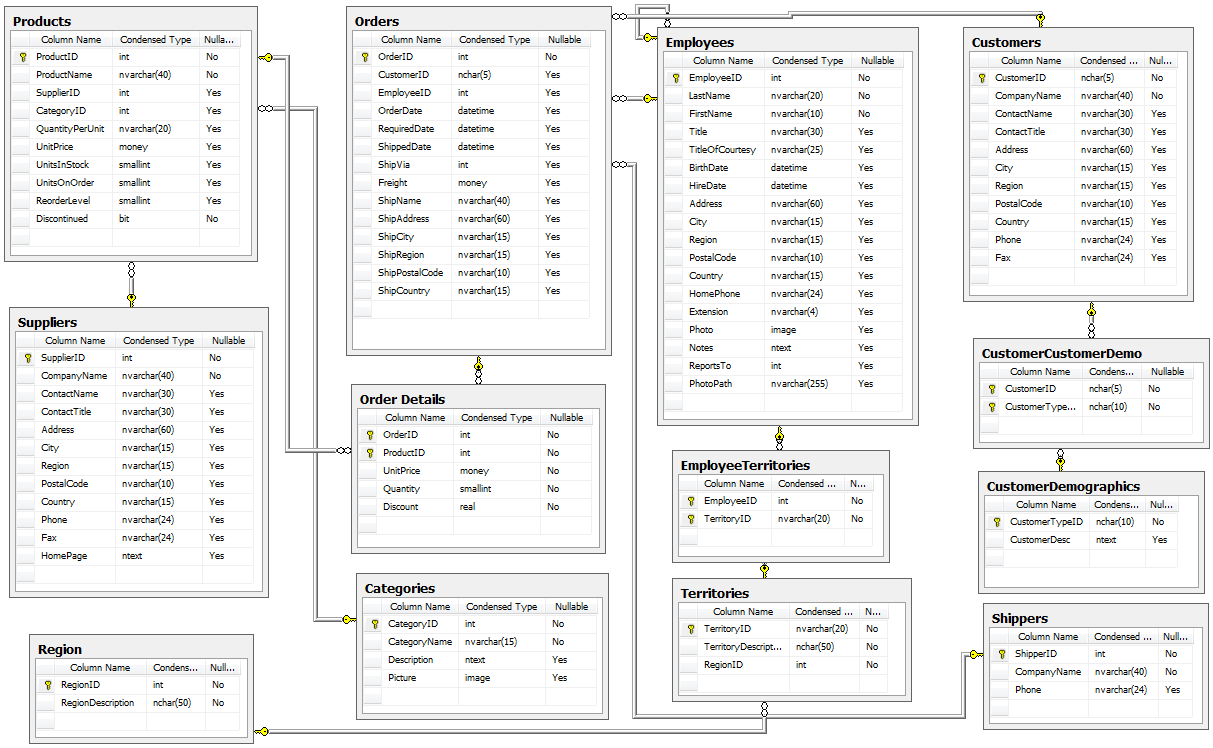

In [6]:
df_discounts= pd.read_sql_query('''SELECT * 
                                   FROM OrderDetail''', engine)
df_discounts.head()

2019-06-05 18:06:46,104 INFO sqlalchemy.engine.base.Engine SELECT * 
                                   FROM OrderDetail
2019-06-05 18:06:46,105 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


First we must check the distribution of our two data sets (discounted vs. no discount). Then we will divide our data into the two categories of having a discount vs. no discount. 

In [7]:
discount_quan= df_discounts[df_discounts['Discount']==0]['Quantity'] #Divide into quantities with discounts
non_discount_quan= df_discounts[df_discounts['Discount']!=0]['Quantity'] #Divide dataframe into quantities without discounts

Here we are checking the distribution to ensure a parametric test is acceptable. 

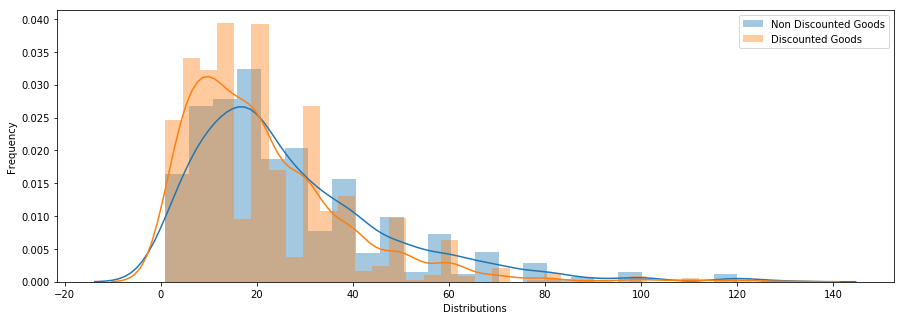

In [8]:
fig= plt.figure(figsize=(15,5))
sns.distplot(non_discount_quan, label='Non Discounted Goods')
sns.distplot(discount_quan, label='Discounted Goods',axlabel='Distributions')
plt.ylabel('Frequency')
plt.legend()

The data looks fairly normal or normal enought to proceed with a parametric t test. We will first state our hypothesises. 

The following are the null and alternative hypothesises for our first question:

$H_0$: there is no difference in order quantity between discounts and non discounted items

$H_\alpha$: there is a difference in order quantity between discounts and non discounted items

In [9]:
t_test(discount_quan, non_discount_quan)
cohens_d(non_discount_quan,discount_quan)

Due to a p-value of, 1.14E-10 , we reject the null hypothesis and accept the alternative hypothesis.
The t-score is -6.48
Cohens D is 0.2862724481729283


Due to the statistical significance of the above test, we should investigate at what levels of discount are statistically significant. To do this we need to do a little bit more leg work in regards to data cleaning and seperating out the data by discount rate. 



In [10]:
df_discounts.groupby('Discount').sum()

,OrderId,ProductId,UnitPrice,Quantity
Discount,,,,
0.00,14042897,54519,34467.91,28599
0.01,11077,73,15.00,2
0.02,22154,52,37.00,4
0.03,33231,94,73.95,5
0.04,11077,20,81.00,1
0.05,1972417,7311,5697.32,5182
0.06,11077,60,34.00,2
0.10,1833523,7164,4354.68,4366
0.15,1672996,6351,3607.22,4456


Due to there only being a few orders for .01, .02, .03, .04, and .06, we will be excluding them from our analysis.

In [11]:
discounts= [.05,.10,.15,.2,.25] #Create a list for the below for loop of discount levels
for i in discounts:
    discounts_t_test= df_discounts[df_discounts['Discount']==i]['Quantity']
    zero_discount= df_discounts[df_discounts['Discount']==0.00]['Quantity']
    print('The following are the results for', i, 'discount level:')
    t_test(discounts_t_test,zero_discount)
    cohens_d(discounts_t_test,zero_discount)

The following are the results for 0.05 discount level:
Due to a p-value of, 1.06E-05 , we reject the null hypothesis and accept the alternative hypothesis.
The t-score is 4.42
Cohens D is 0.3468767736284547
The following are the results for 0.1 discount level:
Due to a p-value of, 1.55E-02 , we reject the null hypothesis and accept the alternative hypothesis.
The t-score is 2.42
Cohens D is 0.19594203057834103
The following are the results for 0.15 discount level:
Due to a p-value of, 1.10E-05 , we reject the null hypothesis and accept the alternative hypothesis.
The t-score is 4.41
Cohens D is 0.3724041317472811
The following are the results for 0.2 discount level:
Due to a p-value of, 3.26E-04 , we reject the null hypothesis and accept the alternative hypothesis.
The t-score is 3.6
Cohens D is 0.3007122542913555
The following are the results for 0.25 discount level:
Due to a p-value of, 1.78E-05 , we reject the null hypothesis and accept the alternative hypothesis.
The t-score is 4.3

In conclusion, there is a __statistical difference__ between a non discount level order and the .05, .1, .15, .20, and .25 discount levels. 

For all of the discount levels listed above, we __rejected the null hypothesis and accepted the alternative hypothesis__ that discount level has a statisitcal significant effect on the quantity of orders.

For my next question, I decided to dig deeper into the different products ordered. I wanted to know what the five most popular items were. From that I wanted to see whether or not being the best selling product really was statistically significant different then being the second, third, fourth, and fifth best selling products. 

### Question 2: Does having the most popular ordered item matter? Or is it ok to just be in the top 5 most popular items.

$H_0$: there is no difference in order quantity between top 5 products 

$H_\alpha$: there is a difference in order quantity between top 5 products

In [36]:
product_quan_df=pd.read_sql_query('''SELECT Product.ProductName, OrderDetail.Quantity AS Quantity 
                                     FROM Product 
                                     LEFT JOIN OrderDetail ON Product.ID = OrderDetail.ProductID 
                                     ''', engine)

2019-06-05 18:28:36,571 INFO sqlalchemy.engine.base.Engine SELECT Product.ProductName, OrderDetail.Quantity AS Quantity 
                                     FROM Product 
                                     LEFT JOIN OrderDetail ON Product.ID = OrderDetail.ProductID 
                                     
2019-06-05 18:28:36,573 INFO sqlalchemy.engine.base.Engine ()


In [39]:
product_quan_df.head()

,ProductName,Quantity
0,Chai,2
1,Chai,3
2,Chai,4
3,Chai,4
4,Chai,5


In [38]:
product_names= ['Raclette Courdavault', 'Gorgonzola Telino', 'Gnocchi di nonna Alice', 'Pavlova'] #Create another list for the for loop to cycle through
for i in product_names:
    top_product= product_quan_df[product_quan_df['ProductName']=='Camembert Pierrot']['Quantity'] #running a t_test for products 2-5 against the best selling product
    product= product_quan_df[product_quan_df['ProductName']==i]['Quantity']
    t_test(product, top_product)
    cohens_d(product, top_product)

Due to a p-value of, 4.76E-01 , we fail to reject the null hypothesis and accept the null hypothesis.
The t-score is -0.72
Cohens D is -0.1397865229208742
Due to a p-value of, 3.95E-01 , we fail to reject the null hypothesis and accept the null hypothesis.
The t-score is -0.85
Cohens D is -0.16900521596108983
Due to a p-value of, 1.58E-01 , we fail to reject the null hypothesis and accept the null hypothesis.
The t-score is -1.42
Cohens D is -0.2830403501660647
Due to a p-value of, 3.48E-01 , we fail to reject the null hypothesis and accept the null hypothesis.
The t-score is -0.94
Cohens D is -0.19542856973212114


We have __failed to reject the null hypothesis__ in all of our experiements. This means, there really is no difference in being the top product or being in the top five most popular products. As long as your item is one of the top 5 popular items you will see it be successful and a cash cow for your business

The company should realize there is not a difference besides quantity ordered in the top selling product vs. its predecessors. Marketing money should be saved as long as the product is in the top 5. 

### Question 3: Is there a statistical signficant difference between the suppliers total profit and quantity ordered by customers? 

$H_0$: there is no difference between the suppliers quanity ordered and the total supplier profit

$H_\alpha$: there is a statistical difference between the suppliers quanity ordered and the total supplier profit

In [15]:
df_suppliers_revenue= pd.read_sql_query('''SELECT p.ProductName, SUM(od.Quantity) AS Quantity, s.CompanyName, (p.UnitPrice - od.UnitPrice) AS Profit  
                                           FROM Product as p
                                           LEFT JOIN Supplier as s ON p.SupplierID=s.ID
                                           LEFT JOIN OrderDetail as od ON p.ID = od.ProductID
                                           GROUP BY ProductName
                                           ORDER BY Profit DESC
 ''', engine)


2019-06-04 21:12:24,061 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, SUM(od.Quantity) AS Quantity, s.CompanyName, (p.UnitPrice - od.UnitPrice) AS Profit  
                                           FROM Product as p
                                           LEFT JOIN Supplier as s ON p.SupplierID=s.ID
                                           LEFT JOIN OrderDetail as od ON p.ID = od.ProductID
                                           GROUP BY ProductName
                                           ORDER BY Profit DESC
 
2019-06-04 21:12:24,062 INFO sqlalchemy.engine.base.Engine ()


In [16]:
df_suppliers_revenue.head(25)

,ProductName,Quantity,CompanyName,Profit
0,Côte de Blaye,623,Aux joyeux ecclésiastiques,52.70
1,Thüringer Rostbratwurst,746,Plutzer Lebensmittelgroßmärkte AG,24.79
2,Mishi Kobe Niku,95,Tokyo Traders,19.40
3,Sir Rodney's Marmalade,313,"Specialty Biscuits, Ltd.",16.20
4,Carnarvon Tigers,539,"Pavlova, Ltd.",12.50
5,Raclette Courdavault,1496,Gai pâturage,11.00
6,Manjimup Dried Apples,886,"G'day, Mate",10.60
7,Tarte au sucre,1083,Forêts d'érables,9.90
8,Ipoh Coffee,580,Leka Trading,9.20
9,Rössle Sauerkraut,640,Plutzer Lebensmittelgroßmärkte AG,9.20


Now that we have our dataframe with the suppliers comapny name, we need to come up with the profit. The profit is just the quantity the supplier sold and the unit price, the company sold said product at.

In [17]:
df_suppliers_revenue['TotalProfit']= df_suppliers_revenue['Profit']*df_suppliers_revenue['Quantity'] #Creating new column for Total Profit

In [18]:
df_suppliers_revenue.sort_values(['CompanyName']).head()

,ProductName,Quantity,CompanyName,Profit,TotalProfit
0,Côte de Blaye,623,Aux joyeux ecclésiastiques,52.7,32832.1
45,Chartreuse verte,793,Aux joyeux ecclésiastiques,3.6,2854.8
54,Laughing Lumberjack Lager,184,Bigfoot Breweries,2.8,515.2
56,Sasquatch Ale,506,Bigfoot Breweries,2.8,1416.8
47,Steeleye Stout,883,Bigfoot Breweries,3.6,3178.8


In [19]:
df_suppliers_grouped=df_suppliers_revenue.groupby('CompanyName').sum().sort_values('TotalProfit', ascending=False)
df_suppliers_grouped.head() #Grouping the companies products together and summing to get each companies profits

,Quantity,Profit,TotalProfit
CompanyName,,,
Aux joyeux ecclésiastiques,1416,56.30,35686.90
Plutzer Lebensmittelgroßmärkte AG,4072,44.79,33149.19
Gai pâturage,3073,17.80,27179.60
"Pavlova, Ltd.",3937,35.65,24843.80
"G'day, Mate",2108,18.60,14856.80


Text(0.5, 1.0, 'Total Supplier Profit')

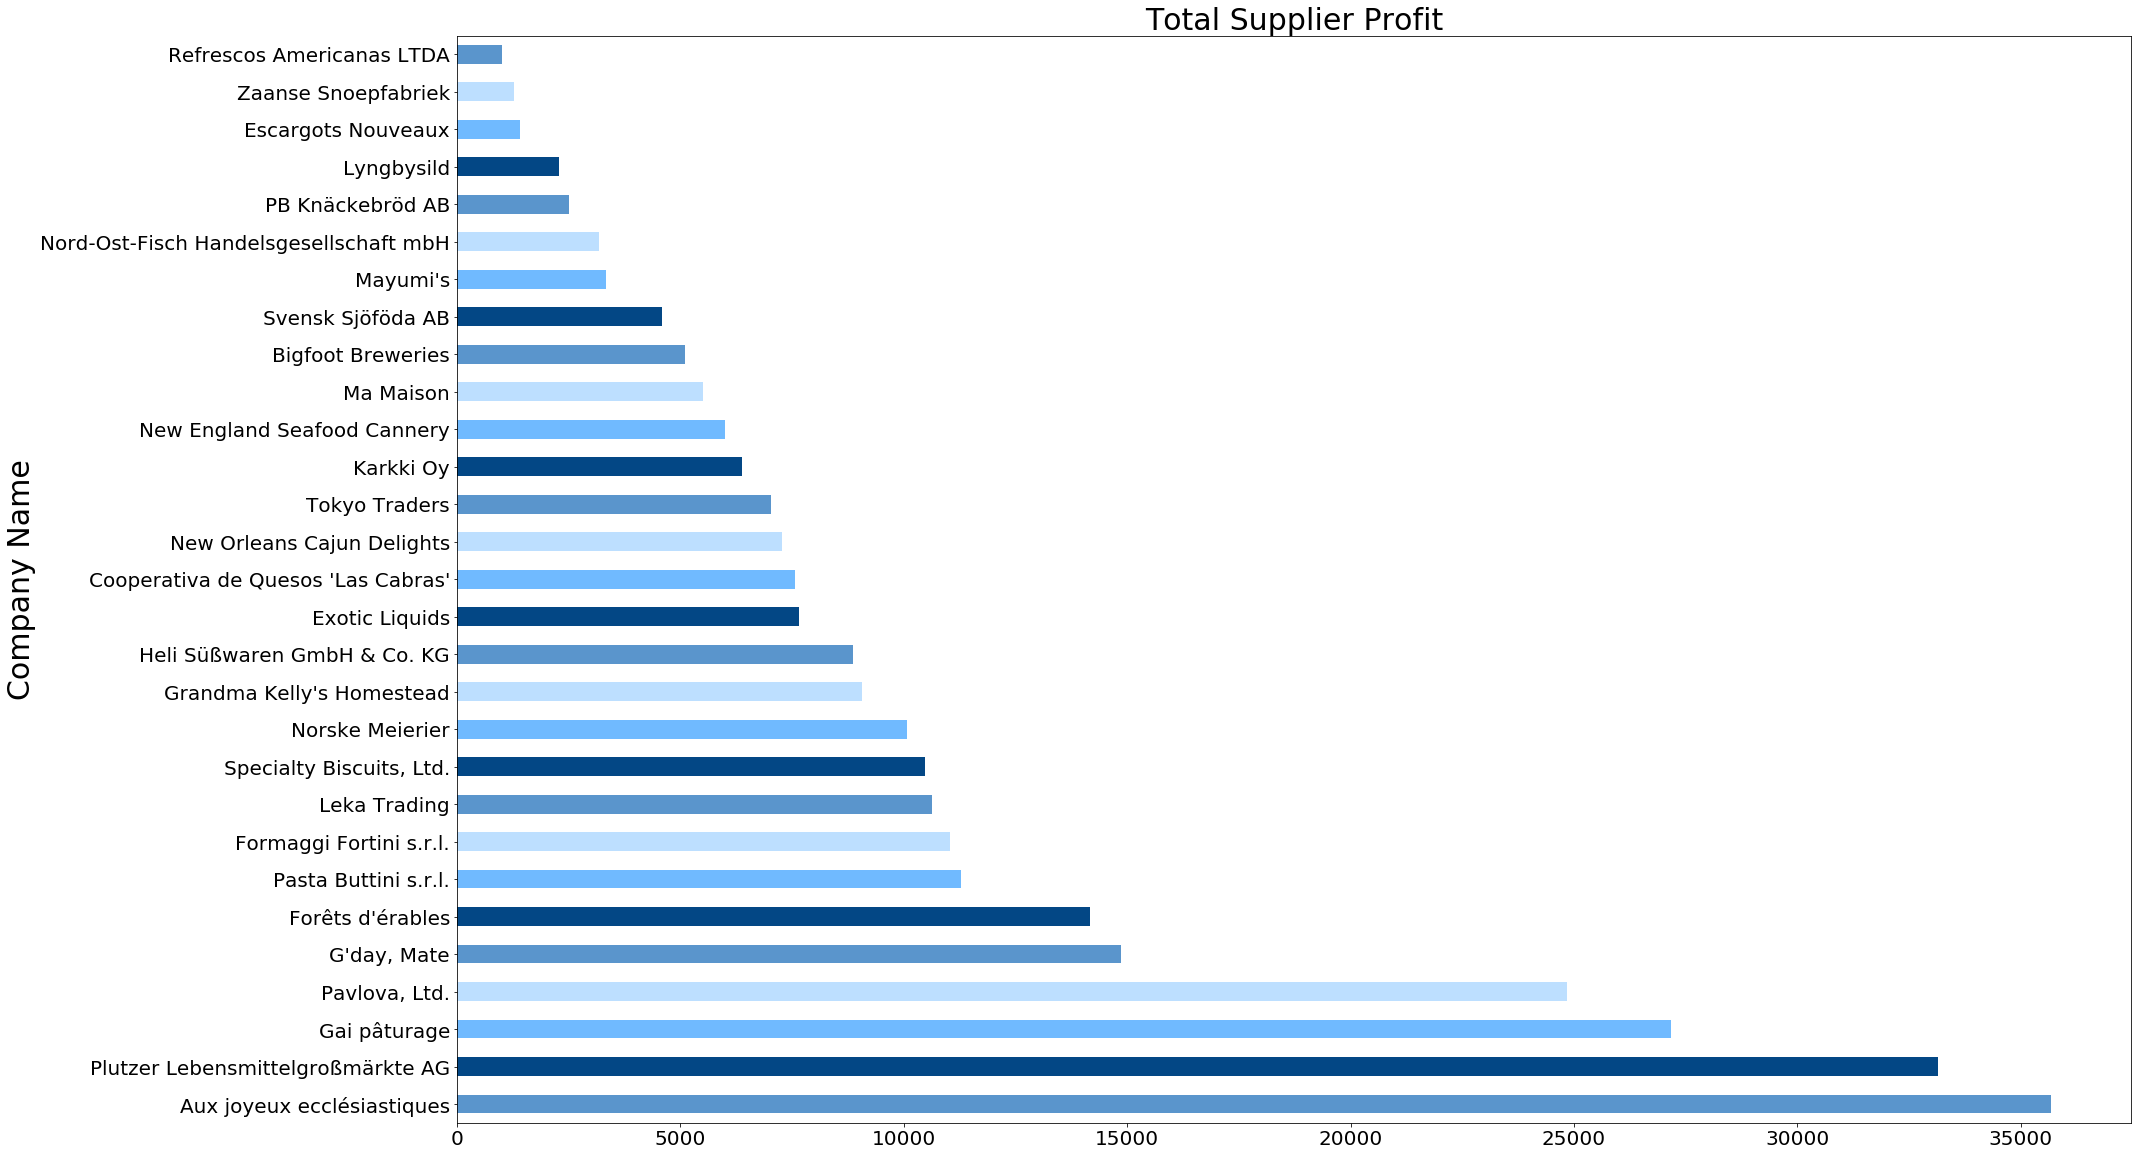

In [20]:
plt.figure(figsize=(30,20))
df_suppliers_grouped['TotalProfit'].plot(kind='barh',fontsize=20, color=['#5A95CC','#034785','#70BAFF','#BDDFFF'])
plt.ylabel('Company Name', fontsize=30)
plt.title('Total Supplier Profit', fontsize=(30)) #Just a graph of the Total Profit for each company

Before we perform any statistical test we have to check the distribution to see if it is ok to use a parametric ANOVA test.

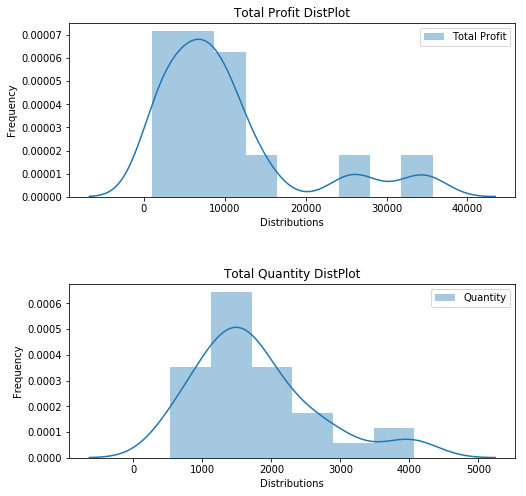

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
fig.subplots_adjust(hspace=.5)
sns.distplot(df_suppliers_grouped['TotalProfit'], label=('Total Profit'), axlabel='Distributions',ax=ax1)
plt.ylabel('Frequency') 
ax1.set_ylabel('Frequency')
ax1.set_title('Total Profit DistPlot')
ax1.legend()
sns.distplot(df_suppliers_grouped['Quantity'], label='Quantity',axlabel='Distributions', ax=ax2)
ax2.set_ylabel('Frequency')
ax2.set_title('Total Quantity DistPlot')
ax2.legend() 

Data is fairly normally distributed excluding a few otliers in Total Profit. We will proceed with a parametric ANOVA test to test the Total Profit vs. the quantity ordered.

In [22]:
formula = 'TotalProfit~Quantity'
lm = ols(formula, df_suppliers_grouped).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq    df          F    PR(>F)
Quantity  1.115148e+09   1.0  24.886413  0.000031
Residual  1.209857e+09  27.0        NaN       NaN


There is a __statistical difference__ between the Total Profit of a supplier and their corresponding shipment quantity. This means we __accept the alternative hypothesis__. 

A business inference can be drawn that the more the supplier is profiting, the more products the company is selling. Makes perfect sense, this is a foundational business principle! Sell! Sell! Sell!

### Question 4: Does the price of a product change based on region? 

$H_0$: there is no difference in the price of product throughout regions

$H_\alpha$: there is a statistical difference between the price of products throughout regions

In [23]:
df_price_region= pd.read_sql_query('''SELECT p.ProductName, c.Region, od.Quantity, od.UnitPrice, od.Discount
                                      FROM Customer c
                                      JOIN [Order] o ON c.Id = o.CustomerId
                                      JOIN OrderDetail od ON od.OrderId = o.Id
                                      JOIN Product as p ON od.ProductID=p.ID
                                      ORDER BY Region
                                                     ''', engine)

2019-06-04 21:12:26,823 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, c.Region, od.Quantity, od.UnitPrice, od.Discount
                                      FROM Customer c
                                      JOIN [Order] o ON c.Id = o.CustomerId
                                      JOIN OrderDetail od ON od.OrderId = o.Id
                                      JOIN Product as p ON od.ProductID=p.ID
                                      ORDER BY Region
                                                     
2019-06-04 21:12:26,824 INFO sqlalchemy.engine.base.Engine ()


Below we will create a formula for price of a product. The formula is the unit price multiplied by the quantity which is then multiplied by one minus the discount rate. 

In [24]:
df_price_region['Price']= df_price_region['UnitPrice']*df_price_region['Quantity']*(1-df_price_region['Discount']) 
df_price_region.head()

,ProductName,Region,Quantity,UnitPrice,Discount,Price
0,Aniseed Syrup,British Isles,30,8.0,0.00,240.0
1,Wimmers gute Semmelknödel,British Isles,9,26.6,0.00,239.4
2,Chang,British Isles,40,15.2,0.00,608.0
3,Inlagd Sill,British Isles,40,15.2,0.25,456.0
4,Raclette Courdavault,British Isles,30,44.0,0.25,990.0


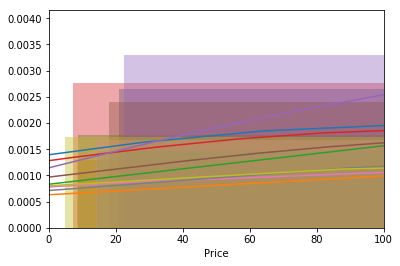

In [25]:
for region in set(df_price_region['Region']):
    region_group = df_price_region.loc[df_price_region['Region'] == region]
    sns.distplot(region_group['Price'])
    plt.xlim(0,100)

Due to data not being normal, we will log transform the Price column. Then we will replot the data using a seaborn distplot. 

In [26]:
df_price_region['Price']= np.log(df_price_region['UnitPrice']*df_price_region['Quantity']*(1-df_price_region['Discount']))
df_price_region.head()

,ProductName,Region,Quantity,UnitPrice,Discount,Price
0,Aniseed Syrup,British Isles,30,8.0,0.00,5.480639
1,Wimmers gute Semmelknödel,British Isles,9,26.6,0.00,5.478136
2,Chang,British Isles,40,15.2,0.00,6.410175
3,Inlagd Sill,British Isles,40,15.2,0.25,6.122493
4,Raclette Courdavault,British Isles,30,44.0,0.25,6.897705


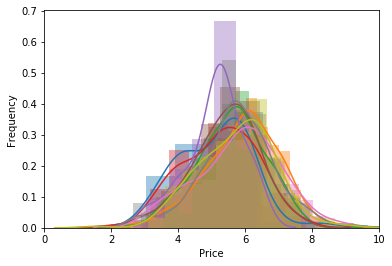

In [27]:
for region in set(df_price_region['Region']):
    region_group = df_price_region.loc[df_price_region['Region'] == region]
    sns.distplot(region_group['Price'])
    plt.xlim(0,10)
    plt.ylabel('Frequency')

In [28]:
df_price_region.groupby('Region').sum()

,Quantity,UnitPrice,Discount,Price
Region,,,,
British Isles,4426,4836.73,9.35,1089.141185
Central America,666,1449.75,0.00,280.912846
Eastern Europe,205,330.10,0.00,81.649096
North America,11314,12370.41,25.74,2475.285368
Northern Europe,3405,3698.73,9.95,824.714972
Scandinavia,1046,1927.48,2.00,380.503137
South America,6359,7481.79,17.80,1697.397214
Southern Europe,2073,3150.21,7.45,717.431214
Western Europe,20221,19359.27,44.15,4369.062655


In [29]:
formula = 'Price~C(Region)'
lm = ols(formula, df_price_region).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq      df          F        PR(>F)
C(Region)   106.890025     8.0  10.264998  3.619410e-14
Residual   2693.077333  2069.0        NaN           NaN


This is the strongest statistic we've gotten thus far! This means as you would expect, we __reject the null hypothesis and accept the alternative hypothesis__.

The price of products will change based on region especially across different continents.

## Conclusion

We learned a lot about the Northwind trading company and it's data. I believe I provided some meaningful data analysis using both t-test and ANOVA statistical tests. My findings are listed below in summary format:
   
   1. Does having the most popular ordered item matter? 
        
        __Result__: Fail to reject the null hypothesis.
        
        __Interpretation__: There is not a statistical significant difference between the top selling product and the                             remaining top four products. Having the most popular item does not matter. 
        
        __Further analysis__: Look to find where it becomes statistically significant. From this cut off point, you                                 would want to spend time and resources to get a product to the specified level in order                               to sell more units.  
        
        
   2. Is there a statistical signficant difference between the suppliers total profit and quantity ordered by              customers?
   
        __Result__: Reject the null, accept the alternative hypothesis.
        
        __Intepretation__: There is a statistically significant difference between the total profit of a company and                            the quanitity ordered.
        
        __Further analysis__: Research whether or not the region plays a factor in where the most profitable                                       companies are located.
        
        
   3. Does the price of a product change based on region?
        
        __Result__: Reject the null, accept the alternative hypothesis.
        
        __Intepretation__: Products will be priced differently in different regions to match their market segments.
        
        __Further analysis__: Drill down further into the regions and look at the price sensitivity of the products                                 in the cities of the regions.

In conclusion, much more research could be done on this database and I feel as if I only touched the surface. Each question could be drilled down even further. From there I believe you could most likely go another level deeper. As with data we must stop at some point, and for this notebook this is the end. I hope you enjoyed it! Thank you!

    